### **Housing Prices Prediciton - Gradient Boosting**

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

### **Import Libraries**

In [92]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import sqlite3
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from scipy.stats import zscore
from category_encoders import TargetEncoder
from sklearn.decomposition import PCA

In [93]:
#class for he db
database_name = 'house_prices.db'

# connect to the db
conn = sqlite3.connect(database_name)

train_df = pd.read_sql_query(
    "SELECT * FROM train", 
    conn)

test_df = pd.read_sql_query(
    "SELECT * FROM test", 
    conn)

# Close the connection
conn.close()

# view of data in the database
pd.set_option('display.max_columns', None)
train_df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave  None      Reg   
1   2          20       RL         80.0     9600   Pave  None      Reg   
2   3          60       RL         68.0    11250   Pave  None      IR1   
3   4          70       RL         60.0     9550   Pave  None      IR1   
4   5          60       RL         84.0    14260   Pave  None      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0        None   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

<Figure size 1400x800 with 0 Axes>

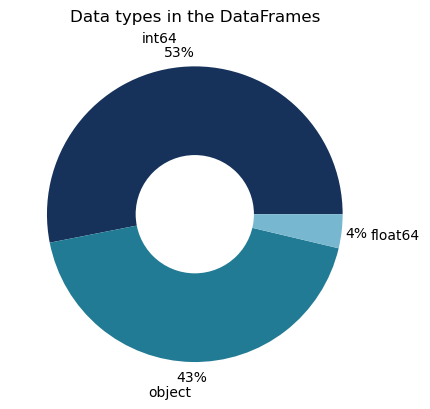

In [94]:
colors = ['#16325B', '#227B94', '#78B7D0' ,'#FFDC7F']
names = ['int64', 'object', 'float64']
datatype_chart = pd.DataFrame(train_df.dtypes.value_counts()).reset_index(names=['data_type', 'count']).sort_values(by='count', ascending=False)

plt.figure(figsize=(14,8))
datatype_chart.plot(kind='pie', y='count',autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2,
                                                  colors=colors,labels=names,legend=False
                                                  )
centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf() 
fig.gca().add_artist(centre_circle)
plt.title('Data types in the DataFrames', fontsize=12)
plt.ylabel('')
plt.show()

In [95]:
pd.set_option('display.max_rows', None)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [96]:
pd.set_option('display.max_columns', None)
train_df.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

        BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean     46.549315   567.240411  1057.429452  1162.626712   346.992466   
std     161.319273   441.866955   438.705324   386.587738   436.528436   
min       0.000000     0.000000     0.000000   334.000000     0.000000   
25%       0.000000   223.000000   795.750000   882.000000     0.000000   
50%       0.000000   477.500000   991.500000  1087.000000     0.000000   
75%       0.000000   808.000000  1298.250000  1391.250000   728.000000   
max    1474.000000  2336.000000  6110.000000  4692.000000  2065.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath  \
count   1460.000000  1460.000000   1460.000000   1460.000000  1460.000000   
mean       5.844521  1515.463699      0.425342      0.057534     1.565068   
std       48.623081   525.480383      0.518911      0.238753     0.550916   
min        0.000000   334.000000      0.000000      0.000000     0.000000   
25%        0.000000  1129.500000      0.000000      0.000000     1.000000   
50%        0.000000  1464.000000      0.000000      0.000000     2.000000   
75%        0.000000  1776.750000      1.000000      0.000000     2.000000   
max      572.000000  5642.000000      3.000000      2.000000     3.000000   

          HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  \
count  1460.000000   1460.000000   1460.000000   1460.000000  1460.000000   
mean      0.382877      2.866438      1.046575      6.517808     0.613014   
std       0.502885      0.815778      0.220338      1.625393     0.644666   
min       0.000000      0.000000      0.000000      2.000000     0.000000   
25%       0.000000      2.000000      1.000000      5.000000     0.000000   
50%       0.000000      3.000000      1.000000      6.000000     1.000000   
75%       1.000000      3.000000      1.000000      7.000000     1.000000   
max       2.000000      8.000000      3.000000     14.000000     3.000000   

       GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  1379.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean   1978.506164     1.767123   472.980137    94.244521    46.660274   
std      24.689725     0.747315   213.804841   125.338794    66.256028   
min    1900.000000     0.000000     0.000000     0.000000     0.000000   
25%    1961.000000     1.000000   334.500000     0.000000     0.000000   
50%    1980.000000     2.000000   480.000000     0.000000    25.000000   
75%    2002.000000     2.000000   576.000000   168.000000    68.000000   
max    2

#### **Sales Price Distribution**

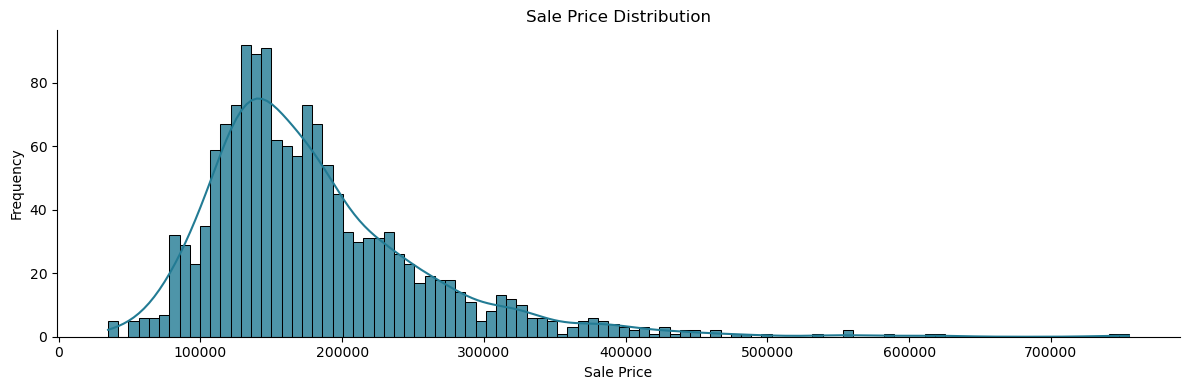

In [97]:
# distribution of the sale price with in the dataset 
sns.displot(train_df['SalePrice'],kde=True, color='#227B94', height=4, aspect=3, bins=100, alpha=0.8) 
plt.title('Sale Price Distribution', fontsize=12)
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.tight_layout()
sns.despine()
plt.show()

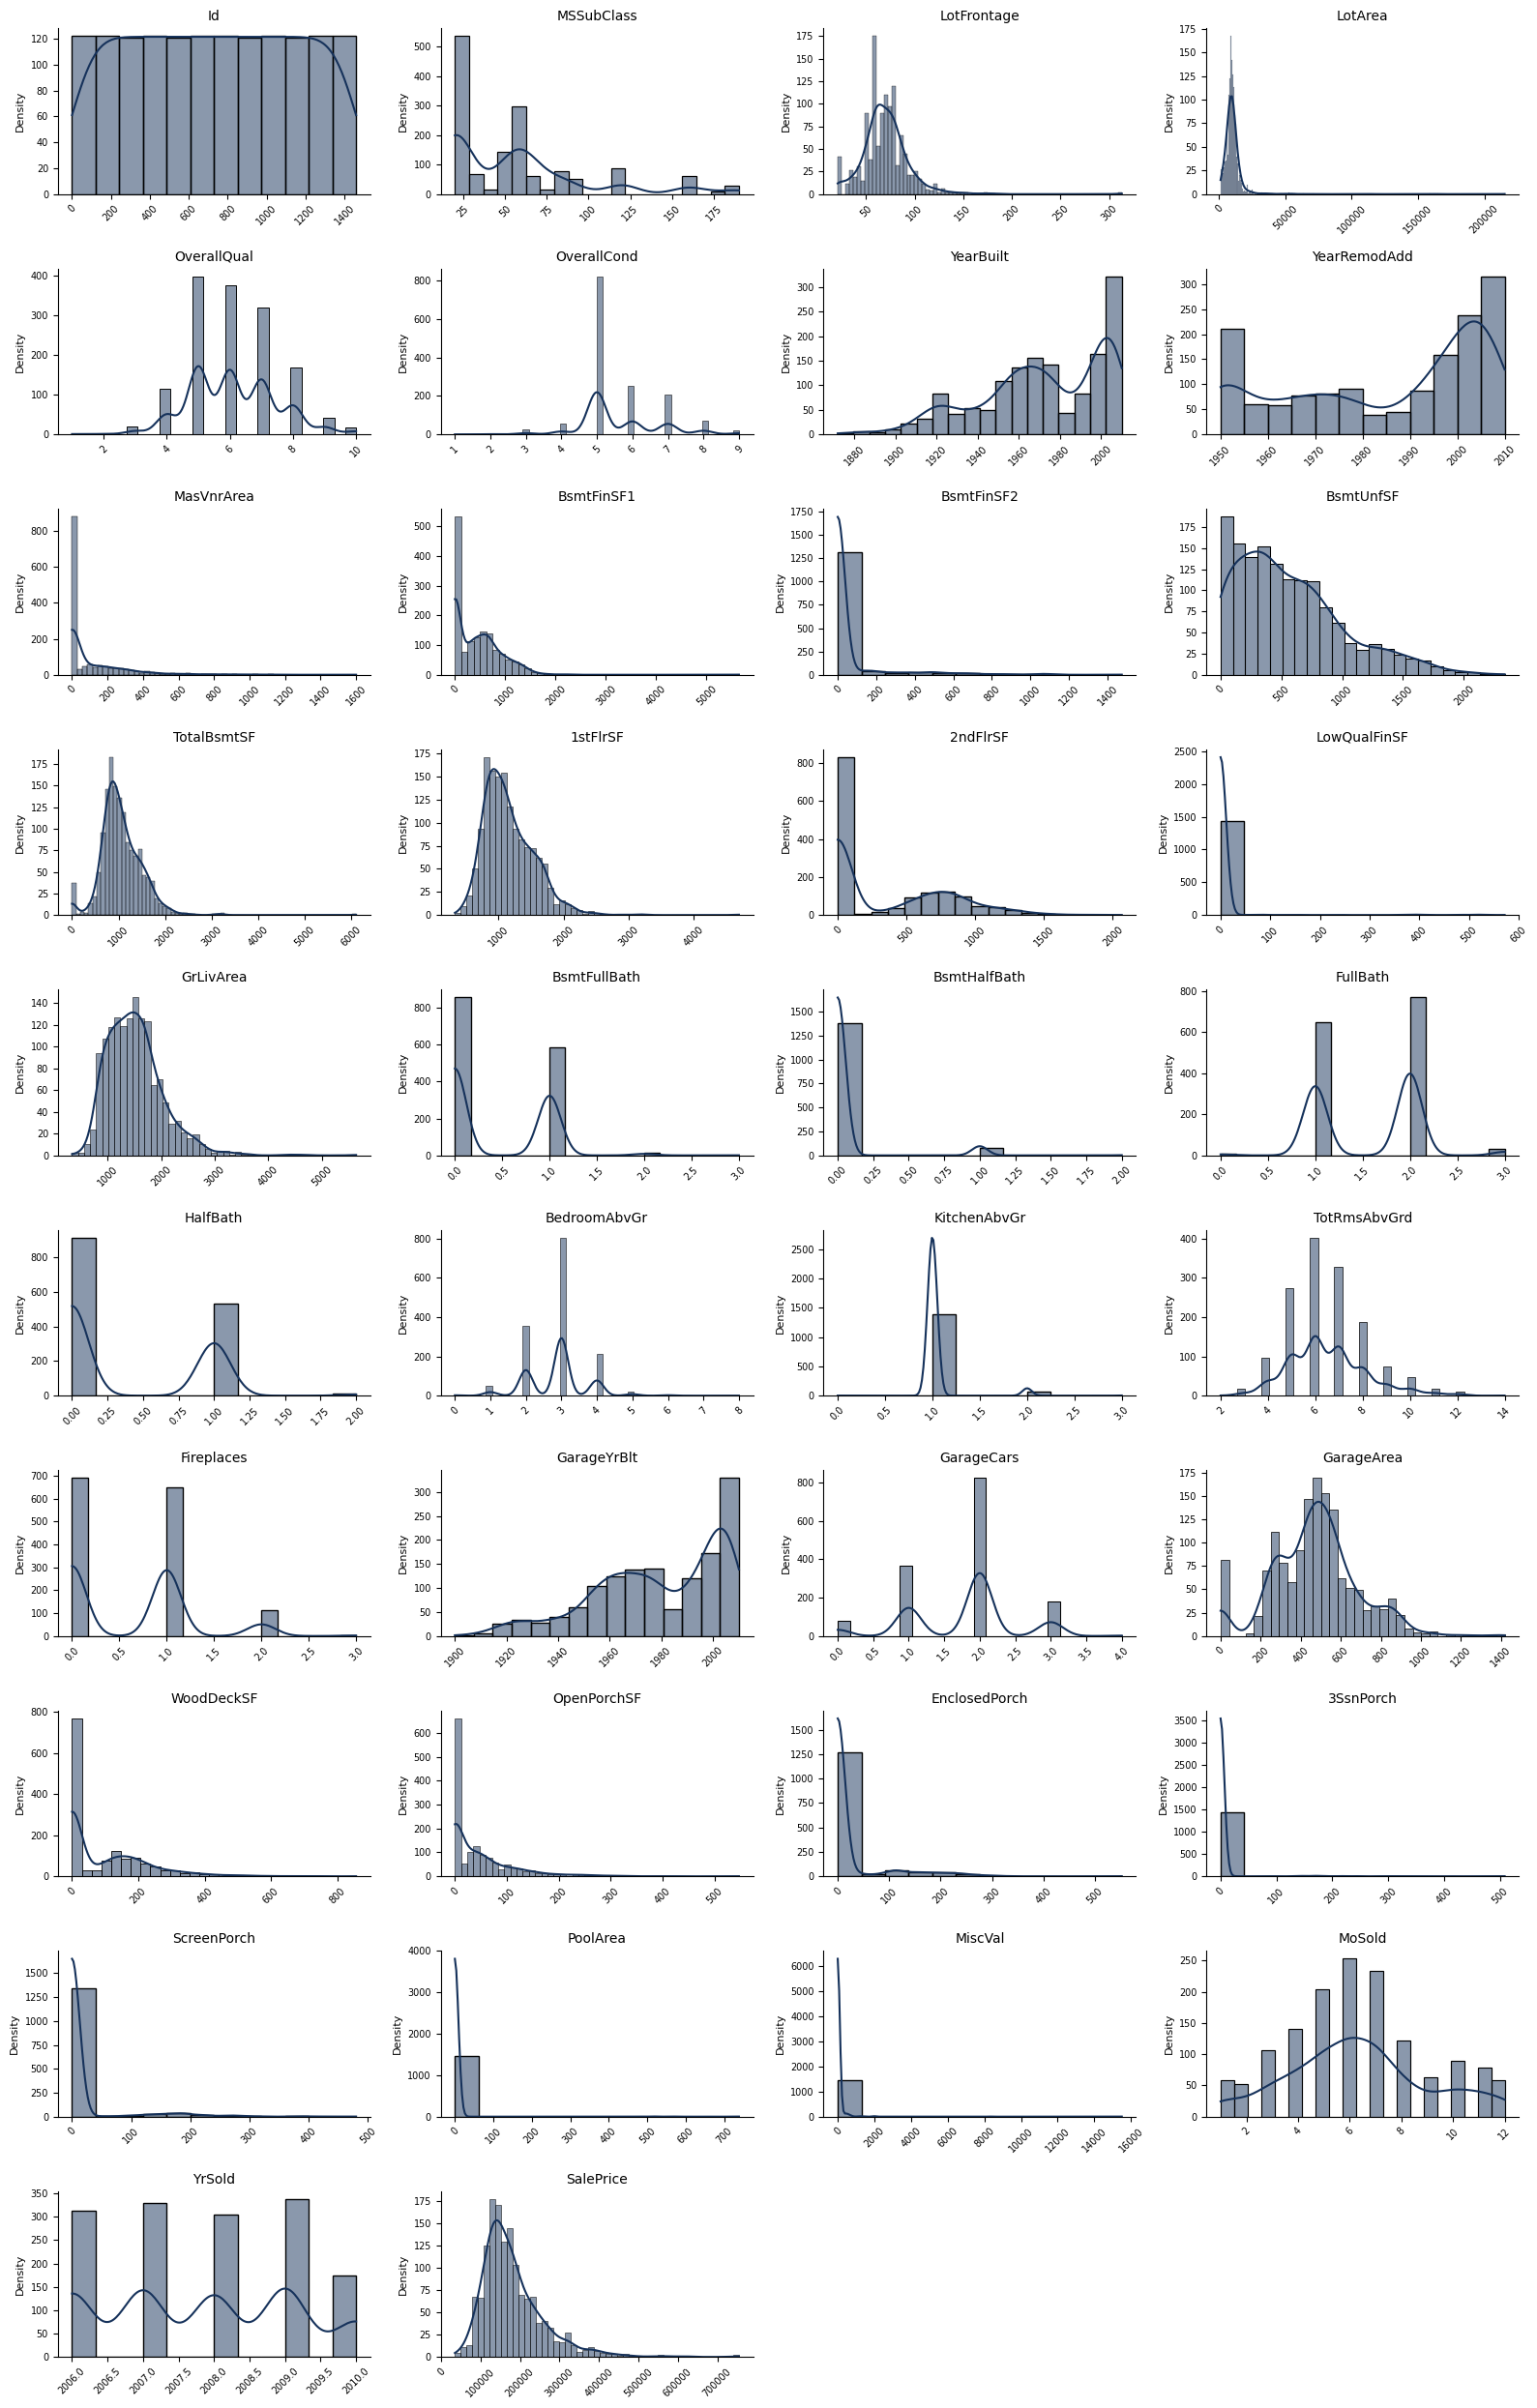

In [98]:
#select only numerical columns
numerical_cols = train_df.select_dtypes(include=['number']).columns
# Define number of columns and calculate rows
ncols = 4 
nrows = (len(numerical_cols) + ncols - 1) // ncols 
#figure size
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2.5 * nrows)) 
axes = axes.flatten() 

#plot for each col
for i, col in enumerate(numerical_cols):
    sns.histplot(train_df[col], kde=True, ax=axes[i], color='#16325B')
    axes[i].set_title(col, fontsize=10)  
    axes[i].tick_params(axis='x', rotation=45, labelsize=7)  
    axes[i].tick_params(axis='y', labelsize=7)
    axes[i].set_xlabel('') 
    axes[i].set_ylabel('Density', fontsize=8)
if len(numerical_cols) < len(axes):
    for j in range(len(numerical_cols), len(axes)):
        fig.delaxes(axes[j])
plt.tight_layout()
sns.despine()
plt.show()

In [99]:
# Suppress all warnings
warnings.filterwarnings('ignore')
numerical_cols = train_df.select_dtypes(include=['number']).columns
numerical_dataset = train_df[numerical_cols]
numerical_dataset['SalePrice'] = train_df['SalePrice']
numerical_dataset.head()

#melting the numerical dataset
numerical_dataset_melted = pd.melt(numerical_dataset, id_vars='SalePrice', var_name='numerical_Variable', value_name='Category')
numerical_dataset_melted[numerical_dataset_melted['numerical_Variable']  == 'Street'].head( )

grouped_stats_num = numerical_dataset_melted.groupby(['numerical_Variable', 'Category'])['SalePrice'].agg([
    'count',
    'mean',
    'sum',
    'std'
]).round(2).reset_index()

grouped_stats_num.head()

numerical_Variable  Category  count      mean     sum       std
0           1stFlrSF     334.0      1  39300.00   39300       NaN
1           1stFlrSF     372.0      1  55000.00   55000       NaN
2           1stFlrSF     438.0      1  60000.00   60000       NaN
3           1stFlrSF     480.0      1  35311.00   35311       NaN
4           1stFlrSF     483.0      7  96628.57  676400  12403.59

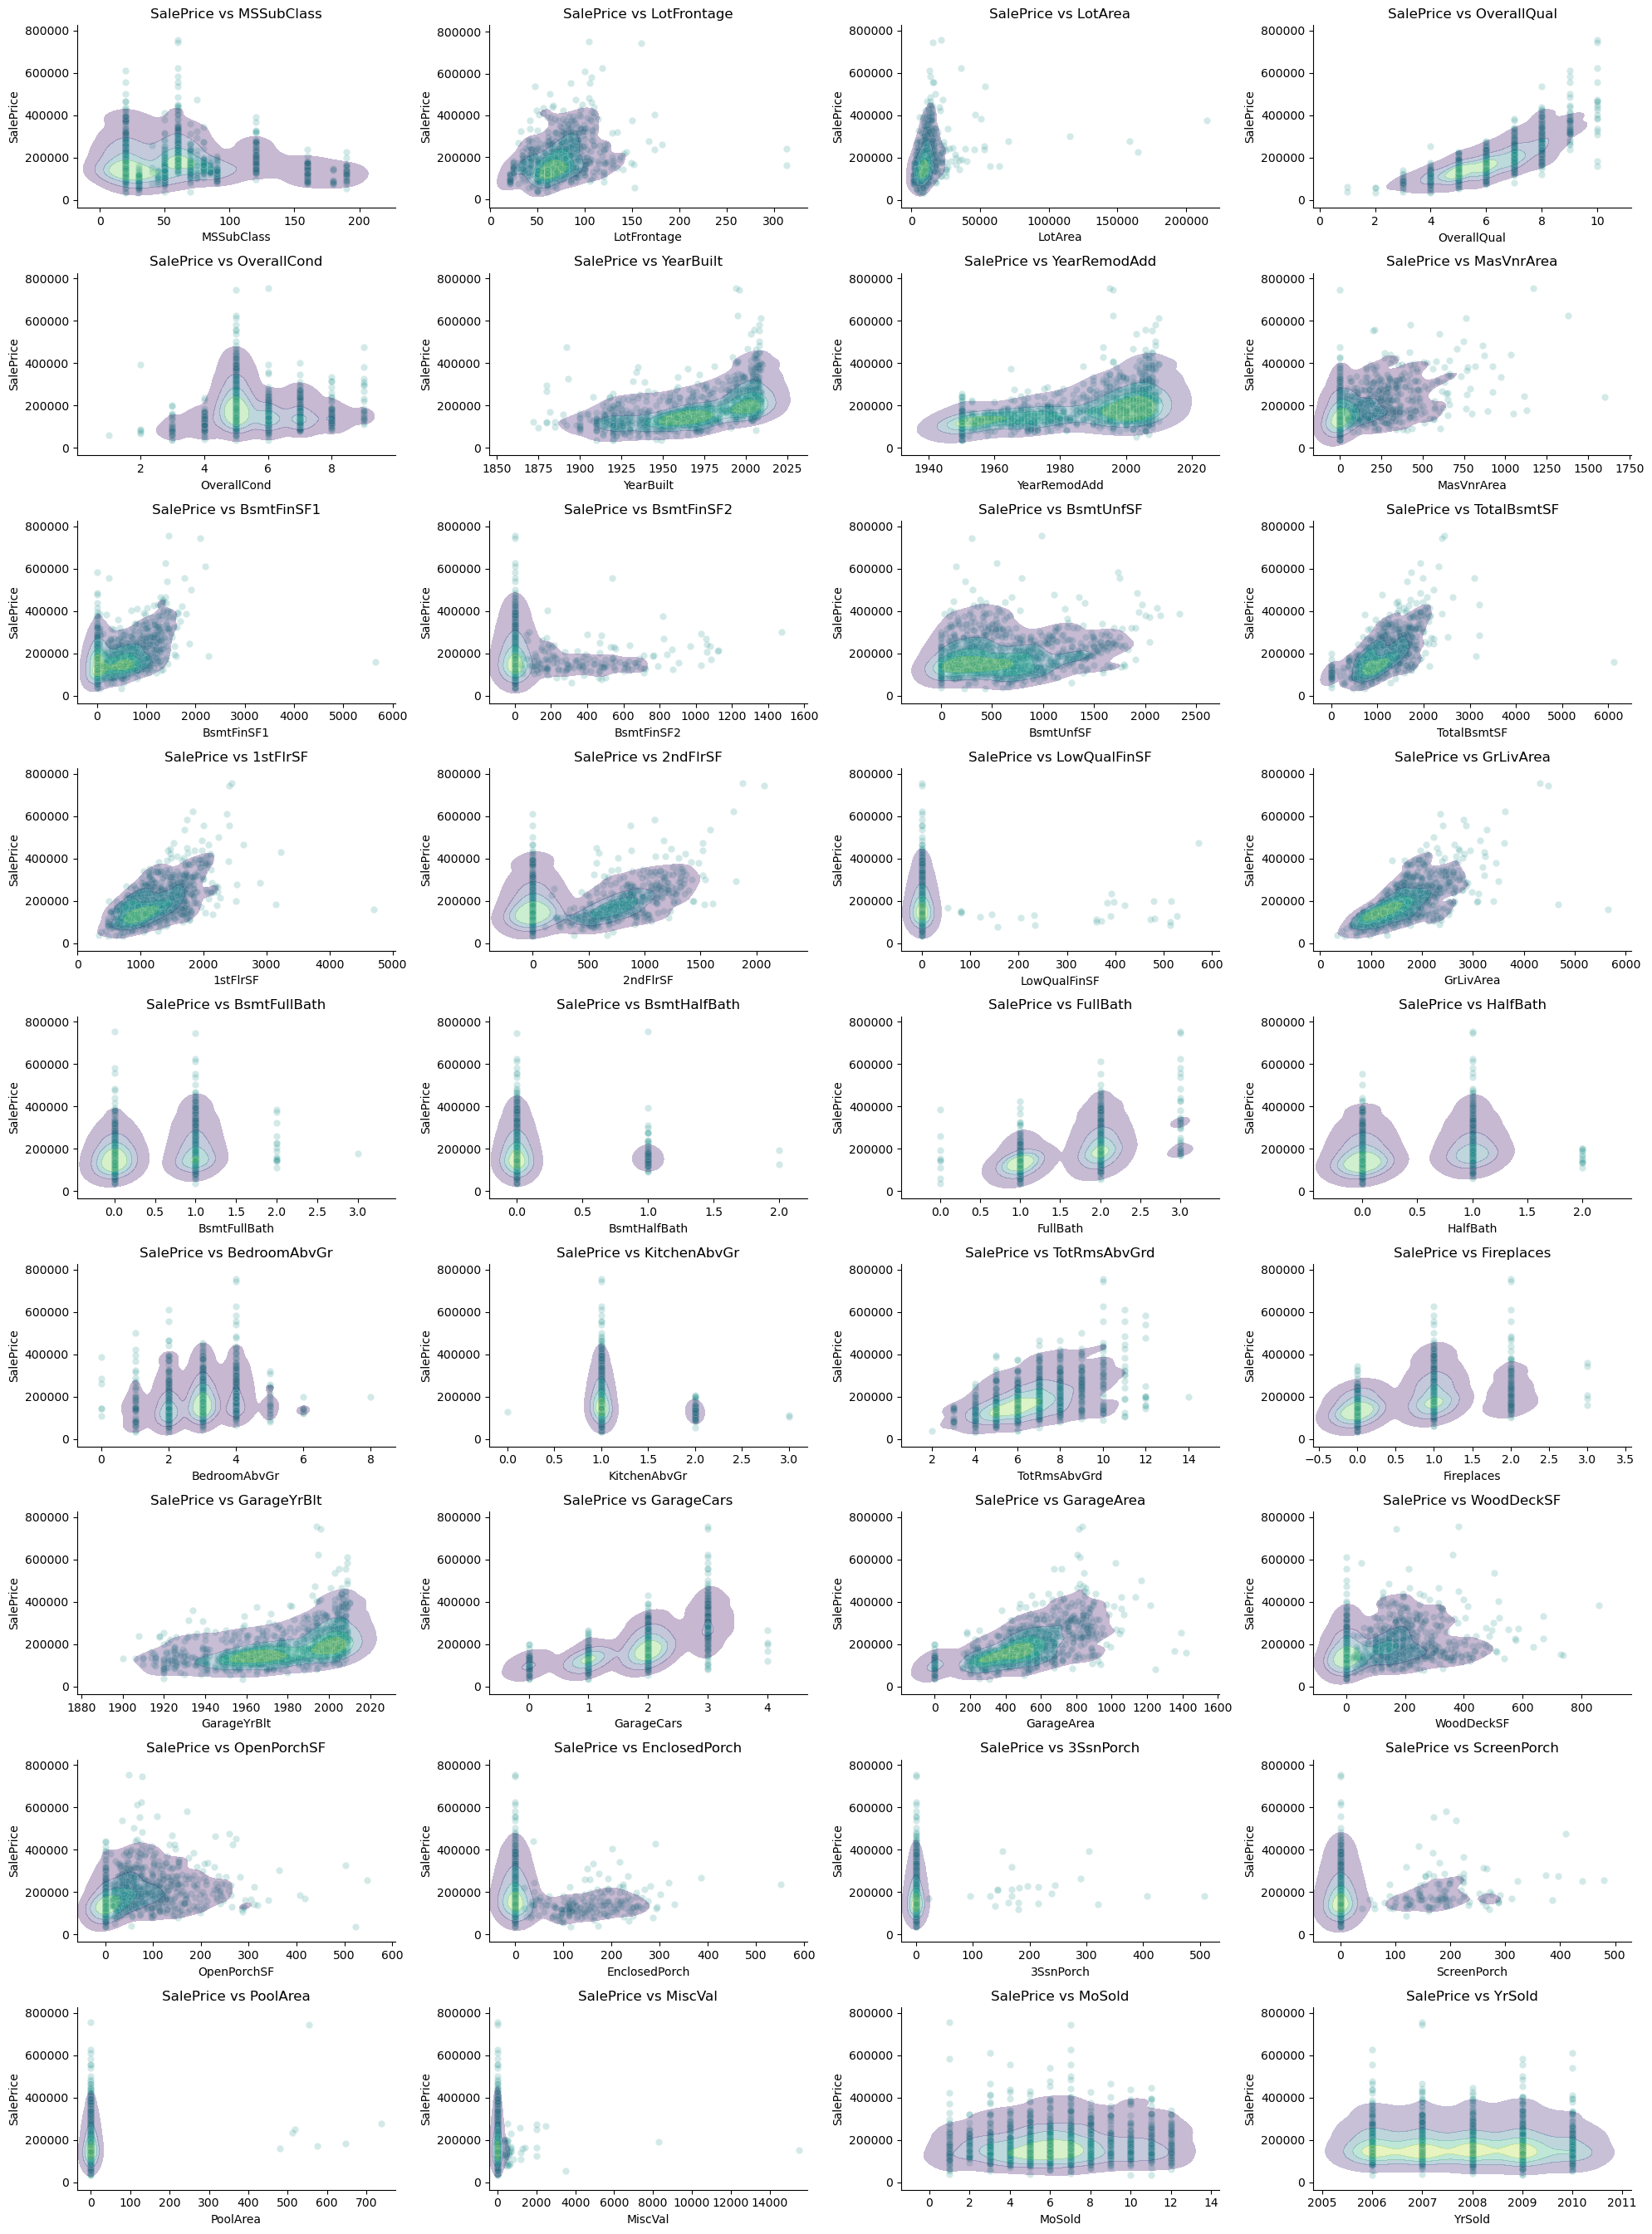

In [100]:
numerical_cols = numerical_dataset.select_dtypes(include=['int64', 'float64']).columns
plot_cols = [col for col in numerical_cols if col not in ['Id', 'SalePrice']]  
# Set up the subplot grid
n_plots = len(plot_cols)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3 * n_rows))
axes = axes.flatten()

#create plot with pallte and color
viridis_color = sns.color_palette('viridis', as_cmap=True)(0.5)
for i, col in enumerate(plot_cols):
    ax = axes[i]
    sns.scatterplot(data=numerical_dataset, x=col, y='SalePrice', ax=ax, color=viridis_color, alpha=0.2)
    sns.kdeplot(data=numerical_dataset, x=col, y='SalePrice', ax=ax, fill=True, alpha=0.3, cmap='viridis', levels=5)
    ax.set_title(f'SalePrice vs {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('SalePrice')

# Hide unused axes
for i in range(n_plots, n_rows * n_cols):
    axes[i].axis('off')

plt.tight_layout()
sns.despine()
plt.savefig('assets/numerical_vals_distribution.png', dpi=120)
plt.show()

In [101]:
train_df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave  None      Reg   
1   2          20       RL         80.0     9600   Pave  None      Reg   
2   3          60       RL         68.0    11250   Pave  None      IR1   
3   4          70       RL         60.0     9550   Pave  None      IR1   
4   5          60       RL         84.0    14260   Pave  None      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0        None   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

### **Categorical Variables**

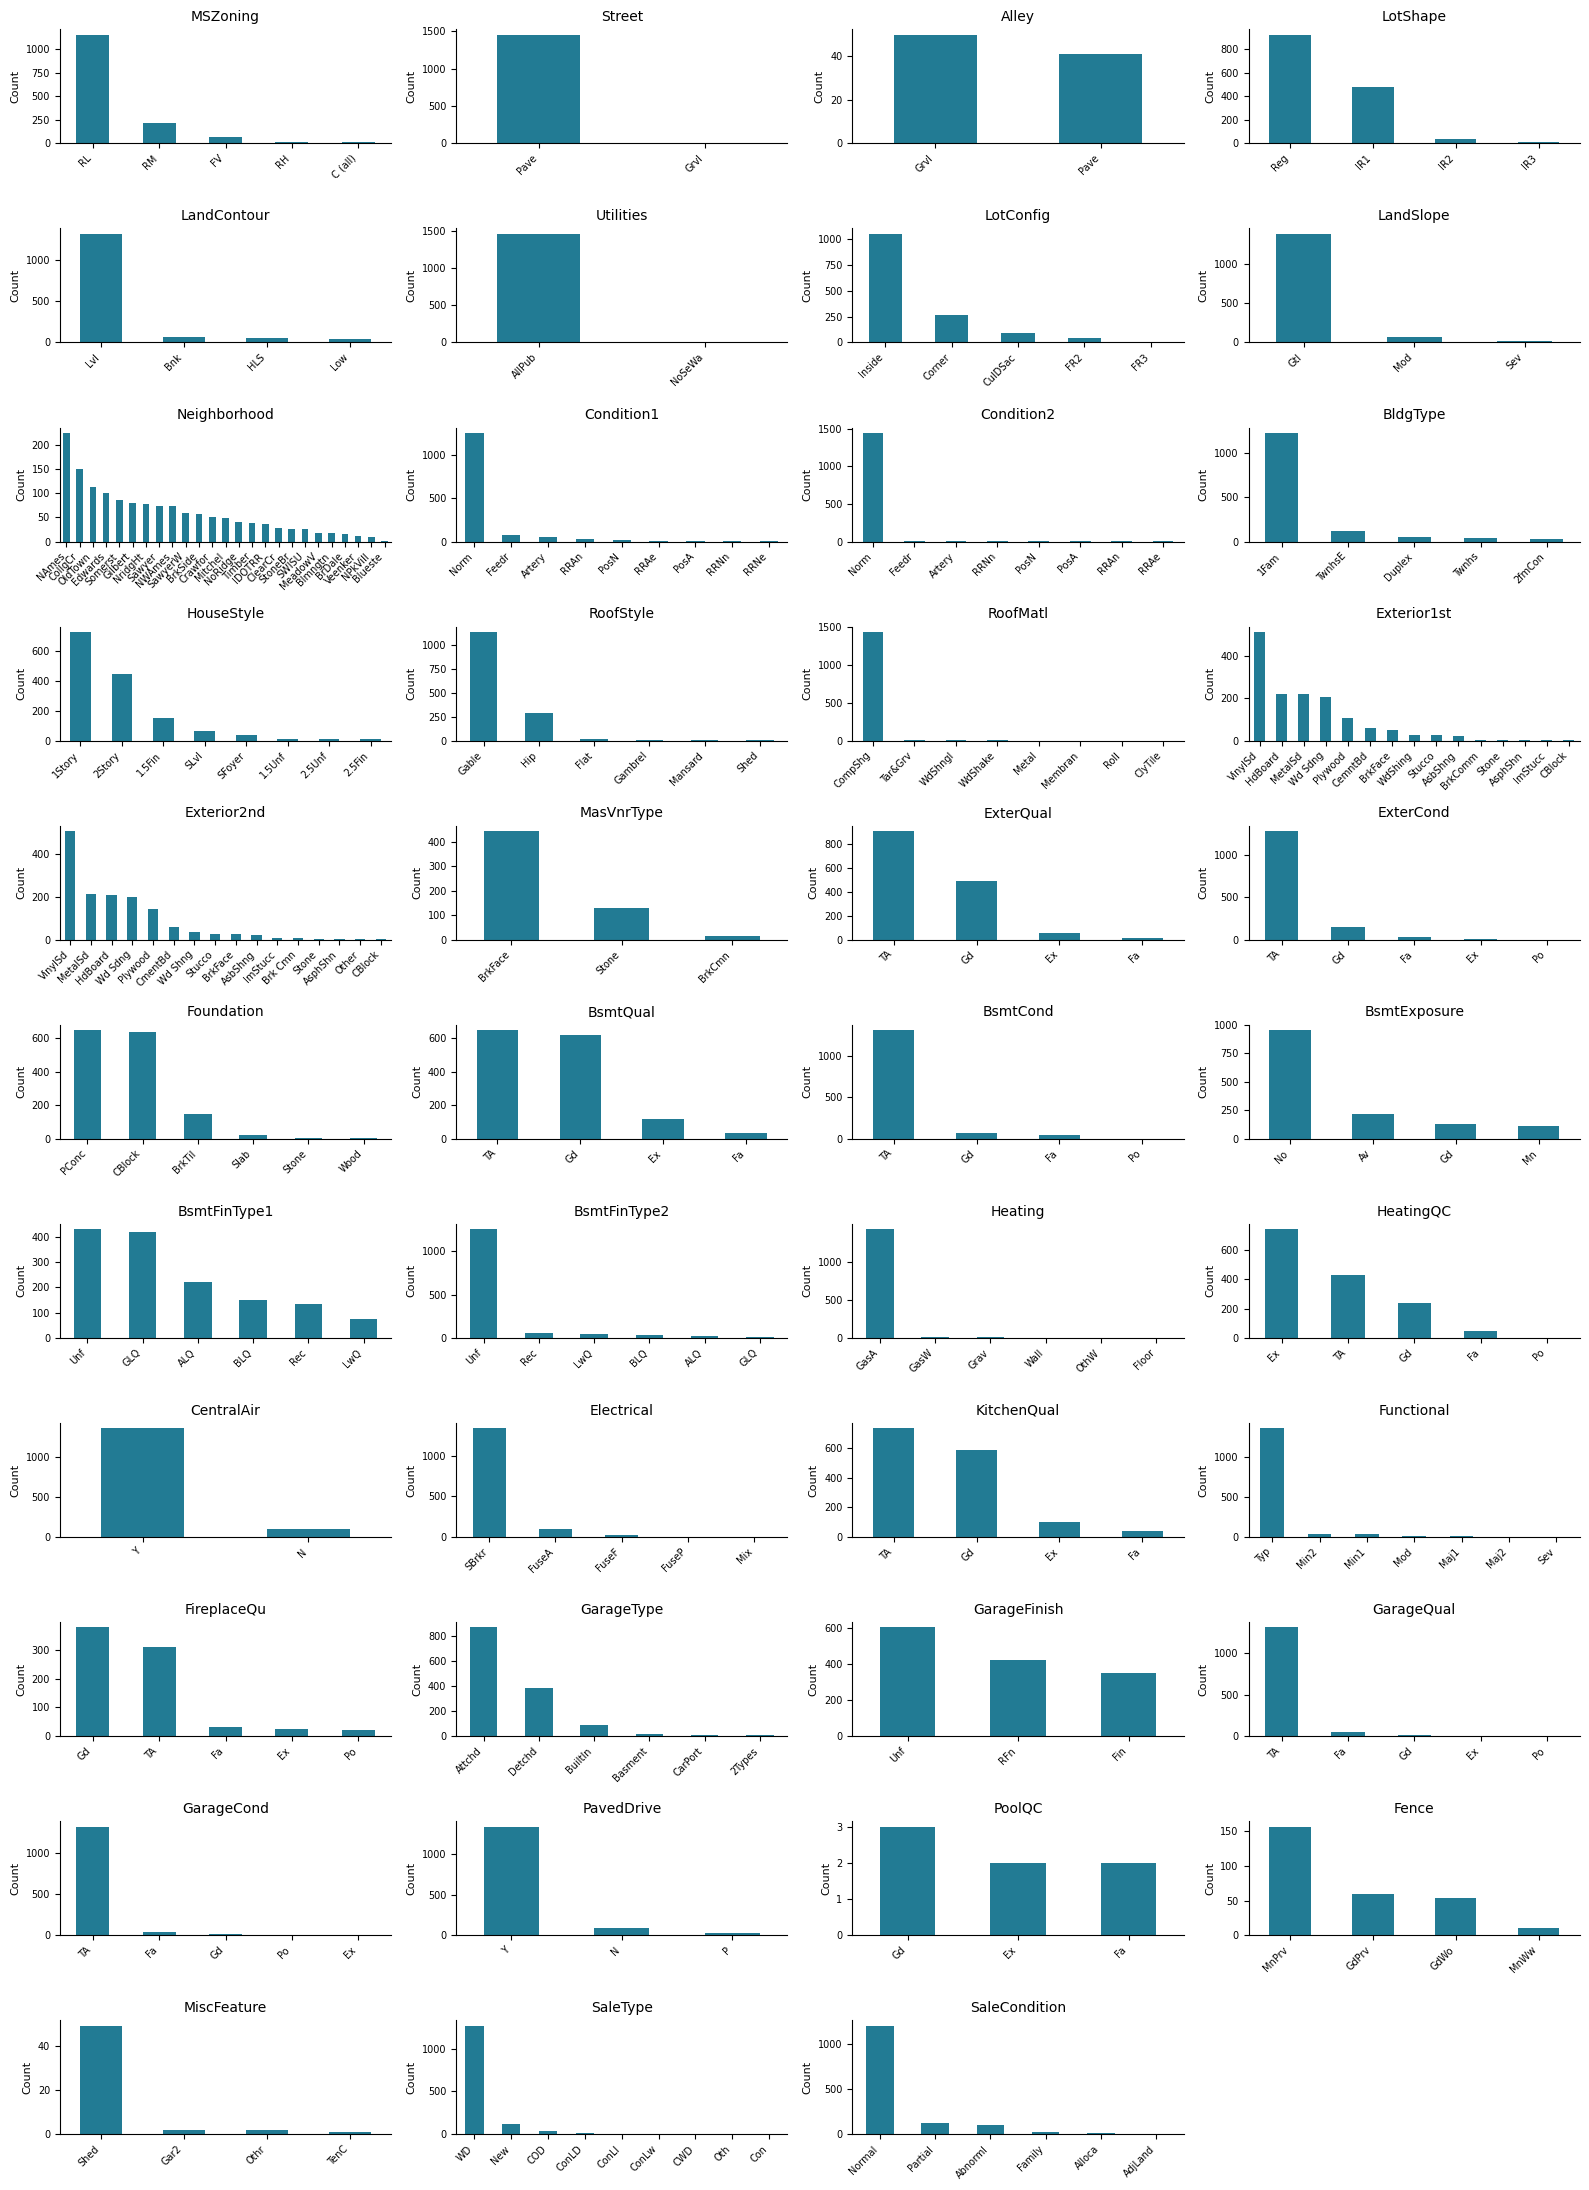

In [102]:
# Select categorical columns
categorical_cols = train_df.select_dtypes(include=['object']).columns
ncols = 4 
nrows = (len(categorical_cols) + ncols - 1) // ncols
#plot for each categ col
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2 * nrows)) 
axes = axes.flatten() 
for i, col in enumerate(categorical_cols):
    train_df[col].value_counts().plot(kind='bar', ax=axes[i], color='#227B94')
    axes[i].set_title(col, fontsize=10) 
    axes[i].set_xlabel('')  
    axes[i].set_ylabel('Count', fontsize=8)  
    axes[i].tick_params(axis='x', rotation=45, labelsize=7)  
    axes[i].tick_params(axis='y', labelsize=7) 
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right') 

# Turn off any unused subplots
if len(categorical_cols) < len(axes):
    for j in range(len(categorical_cols), len(axes)):
        fig.delaxes(axes[j])
plt.tight_layout()
sns.despine()  
plt.show()

#### **Relationship between Categorical Variables and House Price**

In [103]:
# Suppress all warnings
warnings.filterwarnings('ignore')
categorical_cols = train_df.select_dtypes(include=['object']).columns
categorical_dataset = train_df[categorical_cols]
categorical_dataset['SalePrice'] = train_df['SalePrice']
categorical_dataset.head(2)

MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
0       RL   Pave  None      Reg         Lvl    AllPub    Inside       Gtl   
1       RL   Pave  None      Reg         Lvl    AllPub       FR2       Gtl   

  Neighborhood Condition1 Condition2 BldgType HouseStyle RoofStyle RoofMatl  \
0      CollgCr       Norm       Norm     1Fam     2Story     Gable  CompShg   
1      Veenker      Feedr       Norm     1Fam     1Story     Gable  CompShg   

  Exterior1st Exterior2nd MasVnrType ExterQual ExterCond Foundation BsmtQual  \
0     VinylSd     VinylSd    BrkFace        Gd        TA      PConc       Gd   
1     MetalSd     MetalSd       None        TA        TA     CBlock       Gd   

  BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 Heating HeatingQC  \
0       TA           No          GLQ          Unf    GasA        Ex   
1       TA           Gd          ALQ          Unf    GasA        Ex   

  CentralAir Electrical KitchenQual Functional FireplaceQu GarageType  \
0          Y      SBrkr          Gd        Typ        None     Attchd   
1          Y      SBrkr          TA        Typ          TA     Attchd   

  GarageFinish GarageQual GarageCond PavedDrive PoolQC Fence MiscFeature  \
0          RFn         TA         TA          Y   None  None        None   
1          RFn         TA         TA          Y   None  None        None   

  SaleType SaleCondition  SalePrice  
0       WD        Normal     208500  
1       WD        Normal     181500

In [104]:
#melting the categorical dataset
categorical_dataset_melted = pd.melt(categorical_dataset, id_vars='SalePrice', var_name='Categorical_Variable', value_name='Category')
categorical_dataset_melted[categorical_dataset_melted['Categorical_Variable']  == 'Street'].head( )

grouped_stats = categorical_dataset_melted.groupby(['Categorical_Variable', 'Category'])['SalePrice'].agg([
    'count',
    'mean',
    'sum',
    'std'
]).round(2).reset_index()

grouped_stats.head(2)

Categorical_Variable Category  count       mean      sum       std
0                Alley     Grvl     50  122219.08  6110954  34780.78
1                Alley     Pave     41  168000.59  6888024  38370.38

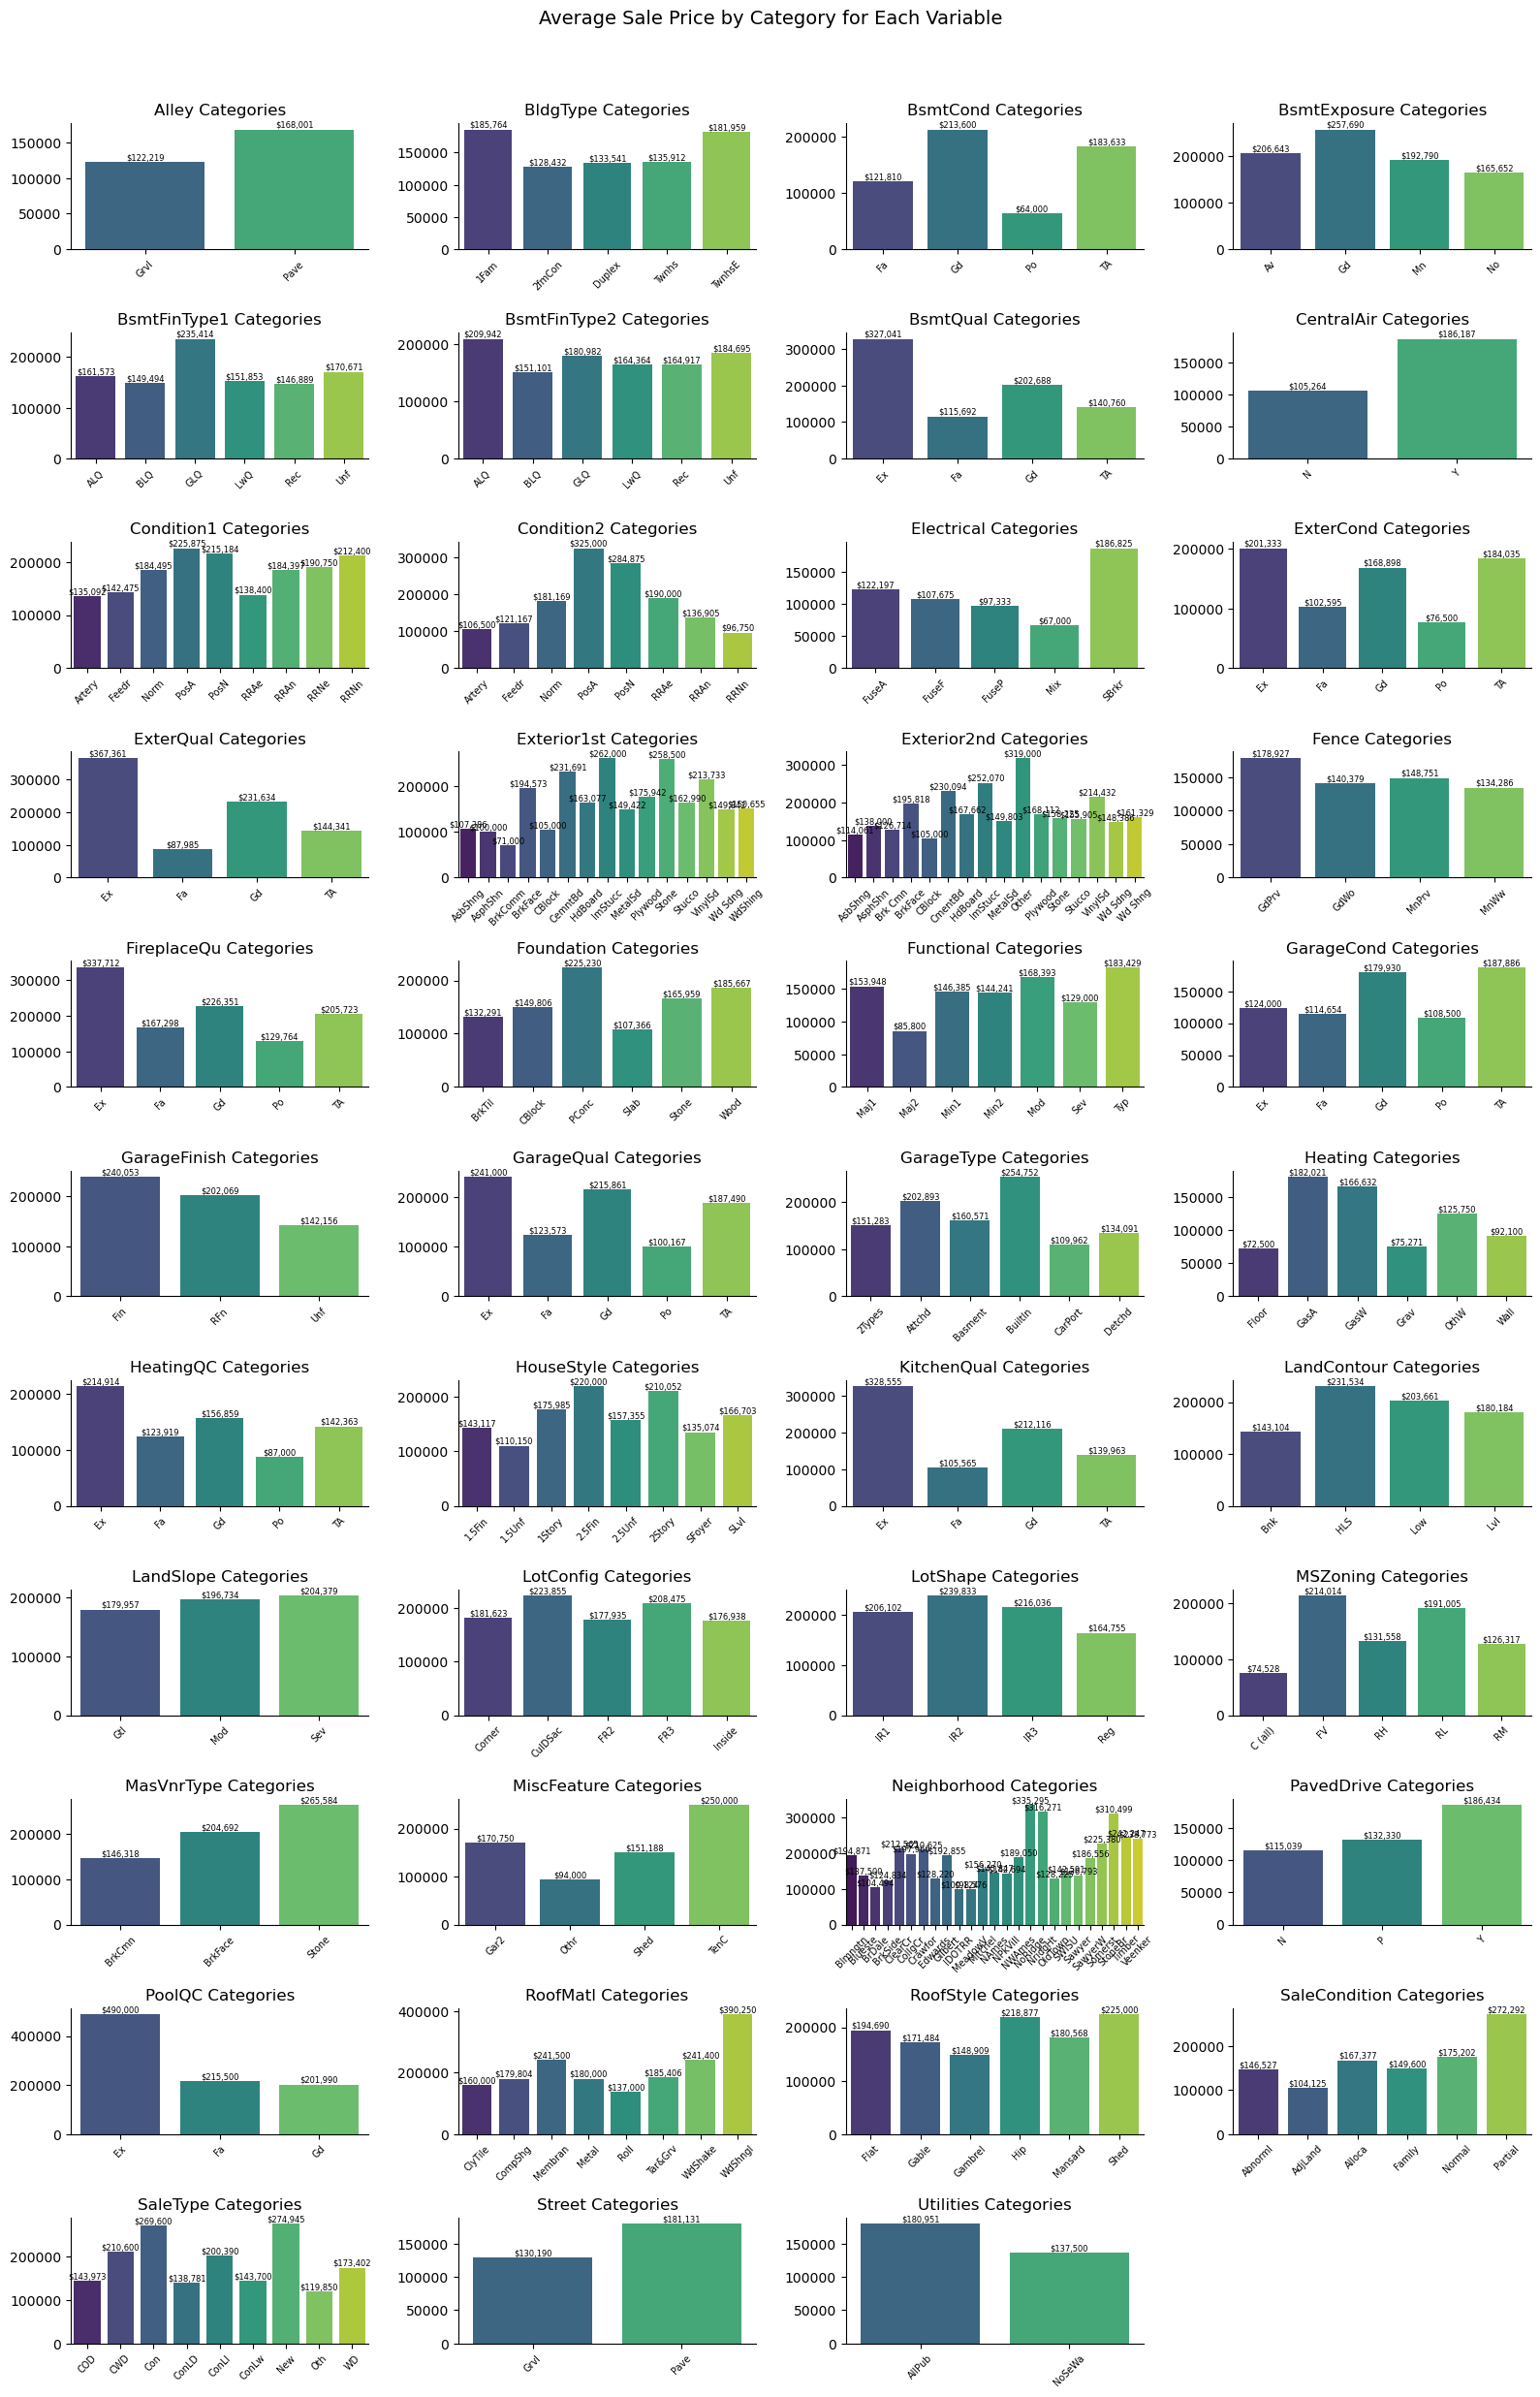

In [105]:
groups = grouped_stats.groupby('Categorical_Variable')
ncols, fig_w = 4, 16  # 4 columns and wider figure
nrows = (len(groups) + 3) // 4  # Calculate rows needed

fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, 2.2 * nrows))  # Wider and shorter
fig.suptitle('Average Sale Price by Category for Each Variable', fontsize=14, y=1.02)

for idx, (category, data) in enumerate(groups):
    ax = axes.flat[idx]
    sns.barplot(data=data, x='Category', y='mean', ax=ax, palette='viridis')
    ax.set(title=f'{category} Categories', xlabel='', ylabel='')
    ax.tick_params(axis='x', rotation=45, labelsize=7)
    for p in ax.patches:
        ax.annotate(f'${p.get_height():,.0f}', (p.get_x()+p.get_width()/2., p.get_height()),
                    ha='center', va='bottom', fontsize=6)

# Turn off empty subplots
[ax.axis('off') for ax in axes.flat[len(groups):]]
plt.tight_layout()
sns.despine()
plt.show()

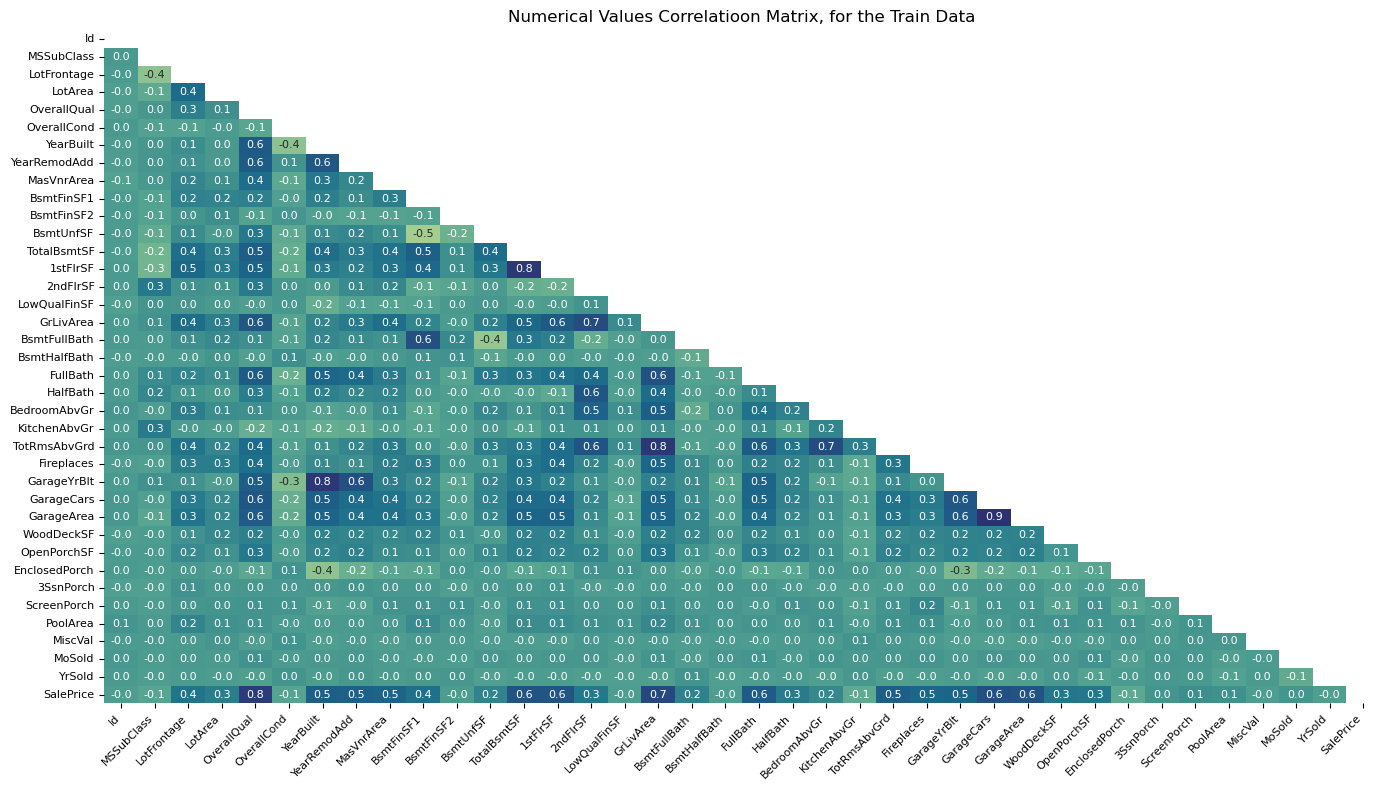

In [106]:
# plot the correlation between the nemerical variables
numerical_cols = train_df.select_dtypes(include=['number'])
corr = numerical_cols.corr()
plt.figure(figsize=(14, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True,cmap='crest',mask=mask,fmt='.1f',cbar=False,annot_kws={"fontsize": 8})
plt.title('Numerical Values Correlatioon Matrix, for the Train Data', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=8)  
plt.yticks(rotation=0, fontsize=8)  
plt.tight_layout()
plt.savefig('assets/numerical_values_correlation.png', dpi=120)
plt.show()

#### **Looking at this:**

- **Size Matters** : Features related to the size of the house (e.g., TotalBsmtSF, 1stFlrSF, GrLivArea, GarageArea) have strong positive correlations with SalePrice.

- **Quality and Condition** : OverallQual and YearBuilt are crucial factors, indicating that both the perceived quality and age of the house influence its selling price.

- **Garage Importance** : Both the number of cars (GarageCars) and the area (GarageArea) in the garage are strongly correlated with SalePrice.

- **Room Count** : The total number of rooms above ground (TotRmsAbvGrd) positively impacts the selling price.

- **Potential Redundancies** : Some features like BsmtFinSF1, BsmtFinSF2, and BsmtUnfSF are highly correlated with TotalBsmtSF, suggesting potential multicollinearity in modeling.

- **Anomalies** : Features like EnclosedPorch and PoolArea show unexpected negative correlations with SalePrice, which might warrant further investigation.

### **Data Cleaning**

In [107]:
train_df.head(3)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave  None      Reg   
1   2          20       RL         80.0     9600   Pave  None      Reg   
2   3          60       RL         68.0    11250   Pave  None      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0        None   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   

  GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual  \
0     Attchd       2003.0          RFn           2         548         TA   
1     Attchd       1976.0          RFn           2         460         TA   
2     Attchd       2001.0          RFn           2         608         TA   

  GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
0         TA          Y           0           61              0          0   
1         TA          Y         298            0              0          0   
2         TA          Y           0           42              0          0   

   ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold  \
0            0         0   None  None        None        0       2    2008   
1            0         0   None  None        None        0       5    2007   
2            0         0   None  None        None        0       9    2008   

  SaleType SaleCondition  SalePrice  
0       WD        Normal     208500  
1       WD        Normal     181500  
2       WD        Normal     223500

##### **Missing Values**

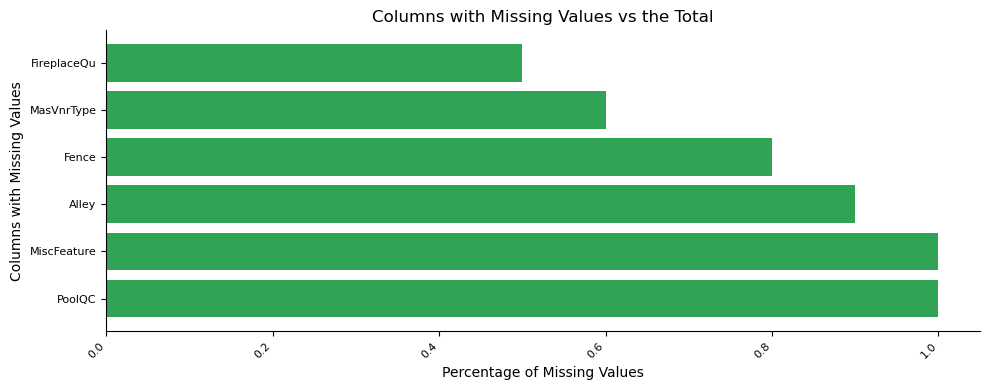

In [108]:
cols_50perc = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)).reset_index().rename(columns={'index': 'column_name', 0: 'missing_count'})
cols_50perc = cols_50perc[cols_50perc['missing_count'] > 0]
cols_50perc['missing_percentage'] = cols_50perc['missing_count'] / len(train_df)
cols_50perc = round(cols_50perc[cols_50perc['missing_percentage'] * 100 > 35] ,1)


plt.figure(figsize=(10, 4))
plt.barh(cols_50perc['column_name'], cols_50perc['missing_percentage'], color='#31a354')
plt.title('Columns with Missing Values vs the Total', fontsize=12)
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Columns with Missing Values')
plt.xticks(rotation=45, ha='right', fontsize=8)  
plt.yticks(rotation=0, fontsize=8)  
plt.tight_layout()
sns.despine()
plt.xticks(rotation=45)
plt.show()


Variables that have more than 35% of the values as missing values will be dropped as it's not feasible to fill them using any statistical methods without influencing the overall dataset. 

In [109]:
drop_cols = cols_50perc['column_name'].values.tolist()
train_df = train_df.drop(columns=drop_cols, axis=1)
#check if any of hte columns are left
train_df.columns.isin(drop_cols)


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

##### **Unique Values**

<Figure size 1200x600 with 0 Axes>

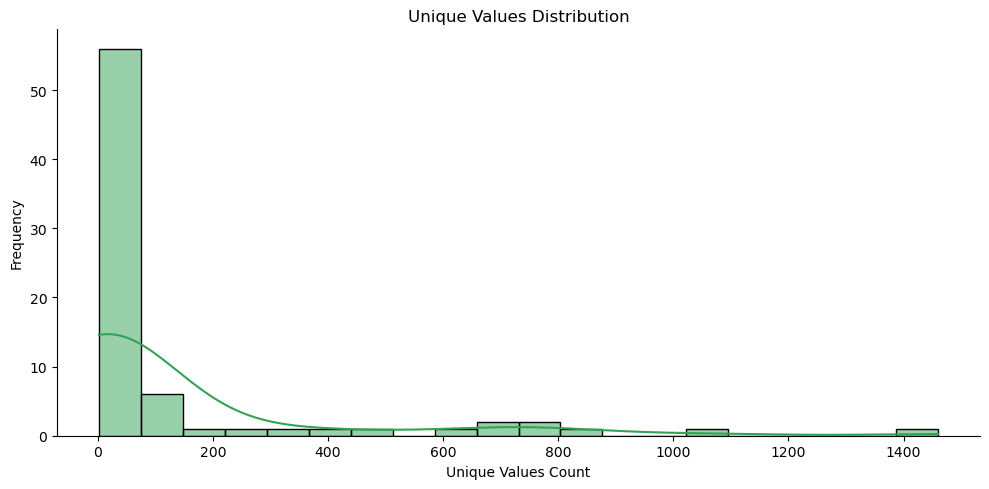

In [110]:
unique_dist = pd.DataFrame(train_df.nunique().sort_values(ascending=False)).reset_index().rename(columns={'index': 'column', 0: 'unique_count'})

plt.figure(figsize=(12, 4))
sns.displot(unique_dist, x='unique_count',color='#31a354',kde=True ,bins=20, height=4, aspect=2)
plt.title('Unique Values Distribution', fontsize=12)
plt.xlabel('Unique Values Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show();

While all columns currently contain unique values, suggesting a lack of duplicates or redundancies, this alone does not confirm the dataset is clean or error-free. Further analysis is necessary to validate data accuracy, consistency, and relevance to the problem at hand.

#### **Duplicate Values**

In [112]:
# check for duplicates with in our dataset 
duplicates = train_df.duplicated().sum()
print(f'There are {duplicates} duplicates in the dataset')

There are 0 duplicates in the dataset


### **Data Distribution & Skewness**

#### What is Skewnewss

Skewness is a dimensionless quantity. It doesn't have units like percentages, meters, or kilograms.

* Skewness of 0: Indicates a perfectly symmetrical distribution.
* Skewness between -0.5 and 0.5: approximately symmetric.
* Skewness between -1 and -0.5 (negative) or between 0.5 and 1 (positive): moderately skewed.
* Skewness less than -1 (negative) or greater than 1 (positive): highly skewed.

> In essence, the higher the absolute value of the skewness, the more the distribution deviates from being symmetrical. The sign tells you which way the tail is leaning.

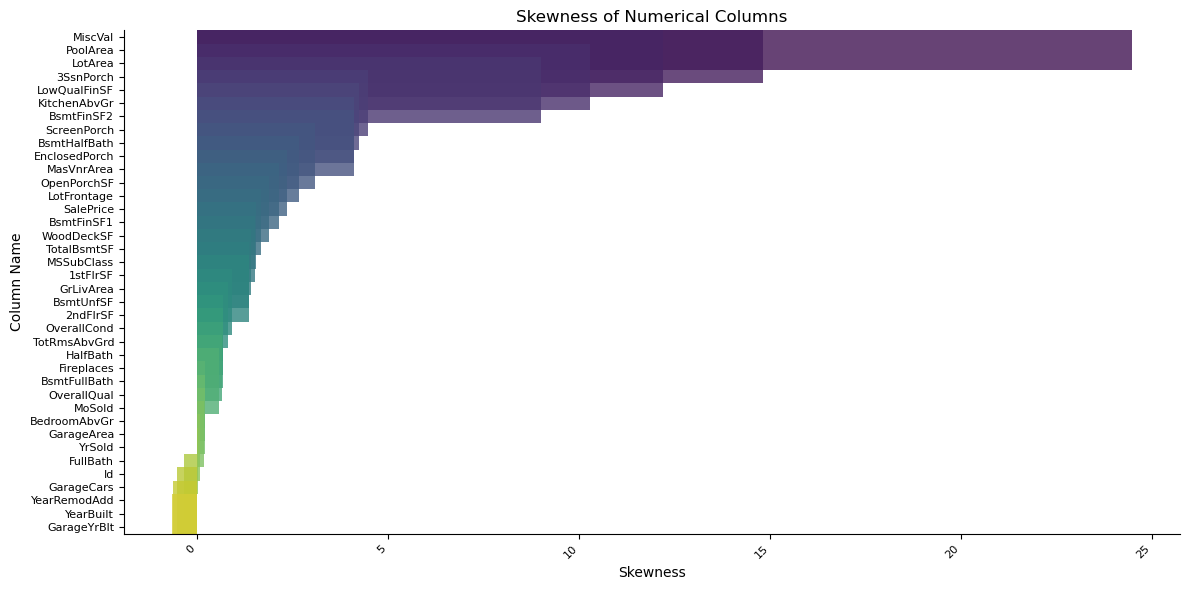

In [113]:
skew_plot = numerical_cols.skew().sort_values(ascending=False)  ##.plot(kind='bar', figsize=(12, 6), color='#227B94')

plt.figure(figsize=(12, 6))
sns.barplot(y=skew_plot.index, x=skew_plot, palette='viridis', alpha=0.8, width=5)
plt.title('Skewness of Numerical Columns', fontsize=12)
plt.xlabel('Skewness',fontsize=10)
plt.ylabel('Column Name', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)  
plt.yticks(rotation=0, fontsize=8)  
sns.despine()
plt.tight_layout()

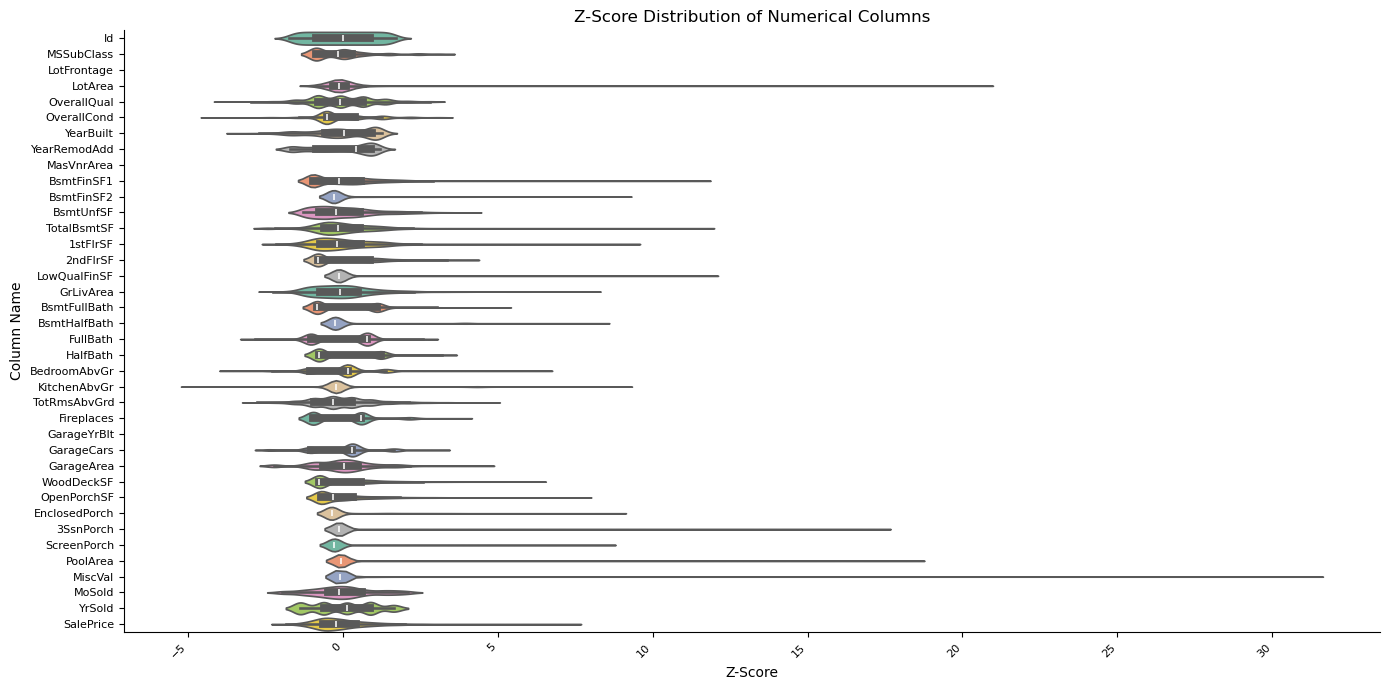

In [114]:
zscore_cols = pd.DataFrame(numerical_cols).apply(zscore)
plt.figure(figsize=(14, 7))
ax = sns.violinplot(data=zscore_cols, orient="h", palette="Set2")
plt.title('Z-Score Distribution of Numerical Columns', fontsize=12)
plt.xlabel('Z-Score', fontsize=10)
plt.ylabel('Column Name', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)  
plt.yticks(rotation=0, fontsize=8)  
plt.tight_layout()
sns.despine()
plt.show()

### **Looking at the Plot**:

- There are some columns with many outliers, several columns show many data points far from the central box, indicating a significant number of potential outliers based on their Z-scores. i.e include ***MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, and MiscVal.***

- There are some columns with fewer outliers: Some columns have fewer or no visible outliers, such as ***YearRemodAdd, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageCars, MoSold, YrSold, and SalePrice. GarageYrBlt and GarageArea*** also show fewer outliers compared to the first group.


Please note all of the skewed variables(columns) need to be addressed since we're working with a regression problem a skewed or expreme values likely affect the the coefficients of regression models, potentially affectin ghte models ablility to generalize to the majority data set. However, since we are using Gradient Boosting algorithm, won't be affected by extreme values as much as distance based or some other algorithms. Nevertheless, handling the skewness of the data can only help since the extremity within the dataset can affect the performance whilst training.

 
**Handling Values**:

 - Address Skewness :- Log Transformation
 - Regularization :- Ridge

## **Data Cleaning**

#### **High Correlation**

```python
    correlated_features = set()
    corr_matrix = train_df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > 0.95:  # Threshold for high correlation
                colname = corr_matrix.columns[i]
                correlated_features.add(colname)
    train_df.drop(columns=correlated_features, inplace=True)
```

### **Preprocessing**

In this step we will first impute missing values but before doing so it's necessary to split them to avoid any type of data leaakage.

Steps:
    - Handle Skewed Data
    - Handle Missing Values 

#### **Split Data**

In [137]:
X = train_df.drop(columns=['SalePrice','Id'])
y = train_df['SalePrice']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 876
Validation set size: 292
Testing set size: 292


#### **Fix Skewed Data**

In [139]:
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = [col for col in numerical_cols if col not in ['Id', 'SalePrice']]  
# Define a functioon for skewness
def handle_skewness(df, numerical_cols):
    skew_plot = df[numerical_cols].skew().sort_values(ascending=False)
    skew_threshold = 2
    highly_skewed_cols = skew_plot[abs(skew_plot) > skew_threshold].index.values
    for col in highly_skewed_cols:
        df[col] = np.log1p(df[col])
    return df 

# Assuming X_train, X_test, X_val are defined DataFrames
X_train_transformed = handle_skewness(X_train, numerical_cols)
X_test_transformed = handle_skewness(X_test, numerical_cols)
X_val_transformed = handle_skewness(X_val, numerical_cols)

#### **Missing Data**

In [141]:
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = [col for col in numerical_cols if col not in ['Id','SalePrice']]
categorical_cols = train_df.select_dtypes(include=['object']).columns

def handle_missing_data(df):
    for col in numerical_cols:
        df[col].fillna(df[col].mean(), inplace=True)
    for col in categorical_cols:    
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df

#convert the values
X_train_imputed = handle_missing_data(X_train_transformed)
X_test_imputed = handle_missing_data(X_test_transformed)
X_val_imputed = handle_missing_data(X_val_transformed)

### **Feature Engineering**

```python
unique_counts = train_df.nunique()
unique_list = pd.DataFrame({
    'column_name': unique_counts.index,
    'unique_count': unique_counts.values,
    'is_categorical': unique_counts.index.isin(categorical_cols)
})
unique_column_names = unique_list[unique_list['is_categorical']]['column_name'].values
categorical_columns_in_df = [col for col in train_df.columns if col in categorical_cols]
```

In [145]:
def handle_binary(df_train, df_test, df_val, col):
    """
    Encode binary columns as 0/1.
    Example: 'Street' (Grvl, Pave) → 0, 1.
    """
    le_ = LabelEncoder() 
    le_.fit(df_train[col])

    df_train[col] = le_.transform(df_train[col])
    df_test[col] = le_.transform(df_val[col])
    df_val[col] = le_.transform(df_val[col])
    
    return df_train, df_test, df_val

binary_cols = ['Street', 'CentralAir', 'Utilities' ]

for col in binary_cols:
    X_train, X_test, X_val = handle_binary(X_train_imputed, X_test_imputed, X_val_imputed, col)


Handling Low Cardinal Columns

In [147]:
def handle_low_cardinality(df_train, df_test, df_val, col):
    
    #One-hot encode object
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    #fit on the training set
    ohe.fit(df_train[[col]])
    
    #transform train/test/val datasets
    train_encoded = pd.DataFrame(ohe.transform(df_train[[col]]), columns=ohe.get_feature_names_out([col]), index=df_train.index)
    test_encoded = pd.DataFrame(ohe.transform(df_test[[col]]), columns=ohe.get_feature_names_out([col]), index=df_test.index)
    val_encoded = pd.DataFrame(ohe.transform(df_val[[col]]), columns=ohe.get_feature_names_out([col]), index=df_val.index)
    
    # Drop original column and merge encoded features
    df_train = pd.concat([df_train.drop(col, axis=1), train_encoded], axis=1)
    df_test = pd.concat([df_test.drop(col, axis=1), test_encoded], axis=1)
    df_val = pd.concat([df_val.drop(col, axis=1), val_encoded], axis=1)
    return df_train, df_test, df_val


low_card_cols = [
    'HouseStyle','RoofMatl','Condition1','Condition2','Functional','SaleCondition','GarageType', 'SaleType',
    'Heating','Foundation','RoofStyle','BldgType','LotConfig','MSZoning','Electrical','LandContour','LotShape' 
        ]

for col in low_card_cols:
    X_train, X_test, X_val = handle_low_cardinality(X_train, X_test, X_val, col)

In [150]:

def handle_high_cardinality(df_train, df_test, df_val, col, target_train):
    
    # Target encode with smoothing
    encoder_ = TargetEncoder(smoothing=10)
    encoder_.fit(df_train[col], target_train)
    
    # Transform all datasets using the same encoder
    df_train[col] = encoder_.transform(df_train[col])
    df_test[col] = encoder_.transform(df_test[col])
    df_val[col] = encoder_.transform(df_val[col])
    return df_train, df_test, df_val

high_card_cols = [
    'Neighborhood','Exterior2nd', 'Exterior1st'
            ]

for col in high_card_cols:
    X_train, X_test, X_val = handle_high_cardinality(X_train, X_test, X_val, col, y_train)

In [152]:
def handle_ordinal(df_train, df_test, df_val, col, mapping, default_value=2):
    """
    mapping: Dictionary defining order (e.g., {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    default_value: Value to assign if missing/unseen categories appear
    """
    
    # Map categories to numbers
    df_train[col] = df_train[col].map(mapping).fillna(default_value).astype(int)
    df_test[col] = df_test[col].map(mapping).fillna(default_value).astype(int)
    df_val[col] = df_val[col].map(mapping).fillna(default_value).astype(int)
    return df_train, df_test, df_val

In [153]:
## mapping for ordinal data columns
ordinal_cols = [
    'ExterQual', 'BsmtQual','BsmtCond','BsmtExposure','KitchenQual','HeatingQC','GarageQual','GarageCond','ExterCond',
    'LandSlope','PavedDrive','BsmtFinType1','BsmtFinType2', 'GarageFinish'
    ]
# Quality/condition mappings (adjust based on your data's actual categories):
qual_mapping = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0, 'missing': 2}
bsmt_exposure_mapping = {'Gd': 3, 'Av': 2, 'Mn': 1, 'No': 0, 'missing': 0}
garage_finish_mapping = {'Fin': 2, 'RFn': 1, 'Unf': 0, 'missing': 0}
paved_drive_mapping = {'Y': 2, 'P': 1, 'N': 0, 'missing': 0}

# Assign mappings to columns (customize as needed):
ordinal_mappings = {
    'ExterQual': qual_mapping,
    'BsmtQual': qual_mapping,
    'KitchenQual': qual_mapping,
    'HeatingQC': qual_mapping,
    'GarageQual': qual_mapping,
    'GarageCond': qual_mapping,
    'ExterCond': qual_mapping,
    'BsmtCond': qual_mapping,
    'BsmtExposure': bsmt_exposure_mapping,
    'LandSlope': {'Gtl': 0, 'Mod': 1, 'Sev': 2, 'missing': 0},
    'PavedDrive': paved_drive_mapping,
    'BsmtFinType1': {'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 2, 'LwQ': 1, 'Unf': 0, 'missing': 0},
    'BsmtFinType2': {'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 2, 'LwQ': 1, 'Unf': 0, 'missing': 0},
    'GarageFinish': garage_finish_mapping
}

# Ordinal columns
for col, mapping in ordinal_mappings.items():
    X_train, X_test, X_val = handle_ordinal(X_train, X_test, X_val, col, mapping)

In [88]:
X_train.shape

(876, 152)

#### **Principal Component Analysis**

**Principal Component Analysis (PCA)**: 

Before building the model it is smart to further explore the structure of the dataset, identify patterns, and potentially reduce dimensionality if need be by performing ***Principal Component Analysis***. 

- PCA transforms your features into a new set of uncorrelated components, ordered by the amount of variance they explain. It’s typically used for:


To capture non-linear relationships with in our columns/data with various techniques, one of them being ***Polynomial Feature Transformation***. Polynomial features are generated by transforming existing features by raising them to powers, enabling us to find a naunce relation-ship between the variables and the target variables. 

- However, since the algorithm for this project XGBoost is capable of finding non-linear relationships with in the dataset adding polynomial features will only add more processing cost and time to the training stage.

In [236]:
pd.set_option('display.max_columns', None)
X_train.head(2)

MSSubClass  LotFrontage   LotArea  Street  Utilities  LandSlope  \
683           20     4.510860  9.328035       1          0          0   
1077          20     4.208627  9.672249       1          0          0   

       Neighborhood  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
683   201235.636912            9            5       2002          2002   
1077  147220.837308            5            5       1969          1969   

        Exterior1st    Exterior2nd  MasVnrArea  ExterQual  ExterCond  \
683   212751.614148  213203.854785    5.375278          3          2   
1077  212751.614148  168216.159719    0.000000          2          2   

      BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  \
683          3         2             2             5    6.966024   
1077         2         2             1             3    4.330733   

      BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  HeatingQC  CentralAir  \
683              0    0.000000        567     7.394493          4           1   
1077             2    6.674561        230     7.000334          4           1   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
683       1668         0           0.0       1668             1           0.0   
1077      1096         0           0.0       1096             1           0.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  \
683          2         0             3      0.693147            3   
1077         1         0             3      0.693147            2   

      TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageFinish  GarageCars  \
683              7           1       2002.0             2           3   
1077             6           0       1969.0             2           1   

      GarageArea  GarageQual  GarageCond  PavedDrive  WoodDeckSF  OpenPorchSF  \
683          702           2           2           2         257     3.828641   
1077         299           2           2           2         240     3.496508   

      EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  \
683             0.0        0.0          0.0       0.0      0.0       7   
1077            0.0        0.0          0.0       0.0      0.0       3   

      YrSold  HouseStyle_1.5Fin  HouseStyle_1.5Unf  HouseStyle_1Story  \
683     2007                0.0                0.0                1.0   
1077    2006                0.0                0.0                1.0   

      HouseStyle_2.5Fin  HouseStyle_2.5Unf  HouseStyle_2Story  \
683                 0.0                0.0                0.0   
1077                0.0                0.0                0.0   

      HouseStyle_SFoyer  HouseStyle_SLvl  RoofMatl_ClyTile  RoofMatl_CompShg  \
683                 0.0              0.0               0.0               1.0   
1077                0.0              0.0               0.0               1.0   

      RoofMatl_Metal  RoofMatl_Roll  RoofMatl_Tar&Grv  RoofMatl_WdShake  \
683              0.0            0.0               0.0               0.0   
1077             0.0            0.0               0.0               0.0   

      RoofMatl_WdShngl  Condition1_Artery  Condition1_Feedr  Condition1_Norm  \
683                0.0                0.0               0.0              1.0   
1077               0.0                0.0               0.0              1.0   

      Condition1_PosA  Condition1_PosN  Condition1_RRAe  Condition1_RRAn  \
683               0.0              0.0              0.0              0.0   
1077              0.0              0.0              0.0              0.0   

      Condition1_RRNe  Condition1_RRNn  Condition2_Artery  Condition2_Feedr  \
683               0.0              0.0                0.0               0.0   
1077              0.0              0.0                0.0               0.0   

      Condition2_Norm  Condition2_PosN  Condition2_RRAe  Condition2_RRAn  \
683               1.0              0.0              0.0              0.0   
1077           

In [164]:
scaler = StandardScaler() 
X_for_PCA = []
X_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)


# Explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance explained:", sum(pca.explained_variance_ratio_))


Explained variance ratio: [0.08771975 0.038769   0.034958  ]
Total variance explained: 0.16144674905293452


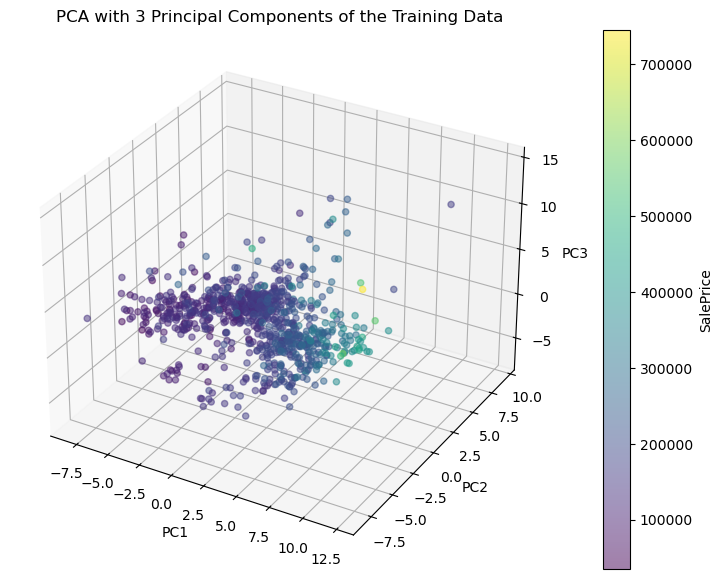

In [ ]:
# 3d plot of the 3 coomponents
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_train, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='SalePrice')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA with 3 Principal Components of the Training Data')
ax.grid(which='minor', linewidth=0.05)
# ax.text(0.0, 0.0, 0.2,transform=ax.transAxes,
#             fontsize=14, fontname='Monospace', color='tab:blue')
# ax.set_yticklabels()
plt.show()

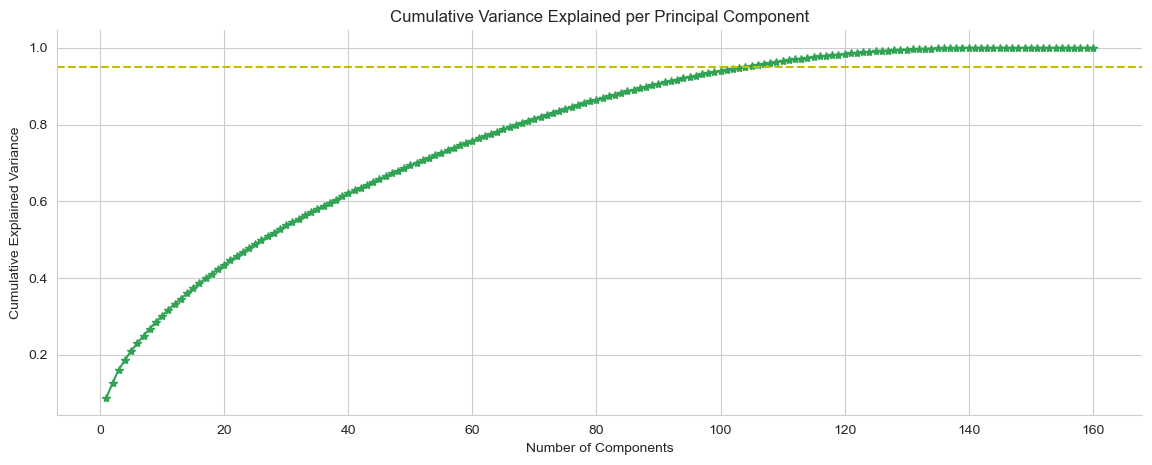

In [ ]:
pca_full = PCA().fit(X_scaled) 
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(14, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='*',color='#31a354')
plt.axhline(y=0.95, color='y', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance Explained per Principal Component')
plt.grid(False)
sns.despine()
plt.show()

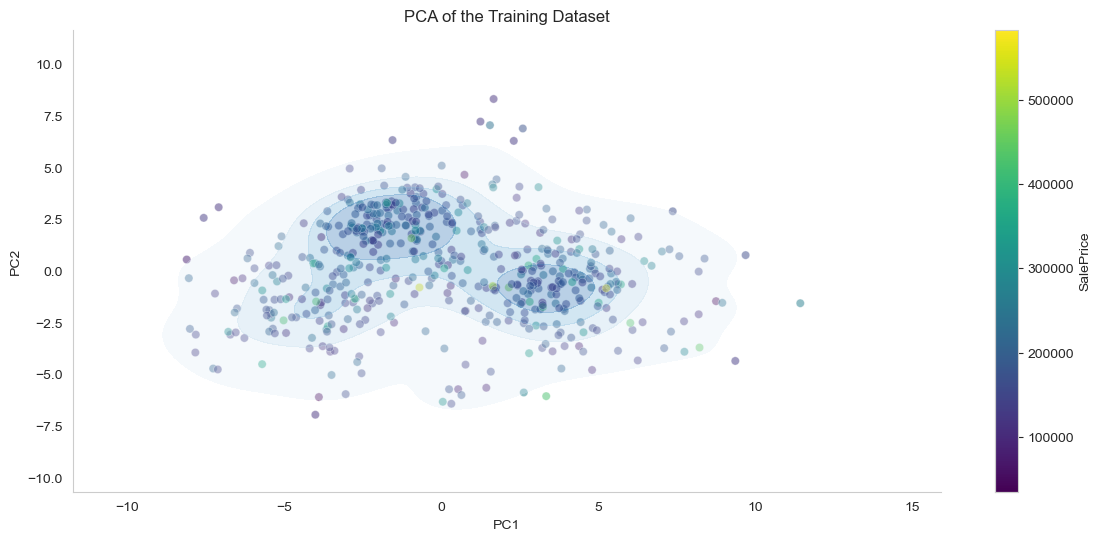

In [235]:
pca_2 = PCA(n_components=2) 
X_pca = pca_2.fit_transform(X_scaled)
df_pca_2 = pd.DataFrame(X_pca).rename(columns={0: "PCA1", 1: "PCA2"})
df_pca_2['SalePrice'] = y_train

# Visualize
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14, 6))
sns.scatterplot(data= df_pca_2, x = 'PCA1', y = 'PCA2',hue='SalePrice', c='darkblue',palette='viridis', alpha=0.5, legend=False, ax=ax)
sns.kdeplot(data=df_pca_2, x= 'PCA1', y = 'PCA2', cmap='Blues', fill=True, alpha=0.3, levels=5,ax=ax)
norm = plt.Normalize(df_pca_2['SalePrice'].min(), df_pca_2['SalePrice'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  
fig.colorbar(sm, ax=ax, label='SalePrice')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA of the Training Dataset')
ax.grid(False)
sns.despine()
plt.savefig('assets/PCA_Analysis.png', dpi=120)
plt.show()

**Looking at this**:

- The dataset is mostly homogeneous, with one main cluster and no clear separate subgroups in this 2D plot the same for the 3D plot.

- PC1 dominates the variance, so the features contributing to PC1 (e.g., possibly SalePrice or related variables) are key to understanding the data’s structure.
- The scattered points at the edges might represent anomalies or special cases—e.g., unusually high or low SalePrice values if that’s the variable involved.
- Most of the data points are similar in their PC1 and PC2 values, with a gradual drop-off in density outward.

### **Modelling**

In [237]:

#Finding best parameters using GridSearch CV
#But since we're using GridSearch cv it will automatically split the train data to a split train - val Thus we need to jon them
from sklearn.model_selection import PredefinedSplit

#combine X_train and X_val
X_train_val = np.vstack([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])

#a split index: -1 for training, 0 for validation
split_index = [-1] * len(X_train) + [0] * len(X_val)
ps = PredefinedSplit(test_fold=split_index)

xgb_model = XGBRegressor()
#define the parameters 
parameters = {
    "learning_rate": (0.01, 0.05, 0.10),
    "n_estimators": [100, 200, 300],
    "max_depth": [ 3, 5, 8],
    "min_child_weight": [ 1, 3, 5, 7],
    "gamma":[ 0.0, 0.1, 0.2],
    "colsample_bytree":[ 0.3, 0.4]
        }

##fiting parameters for early stopping
fit_params = {
    "eval_set": [(X_val, y_val)],
    "early_stopping_rounds": 10,
    "verbose": True
        }

#create a class
gcv = GridSearchCV(
    estimator = xgb_model,
    param_grid = parameters,
    scoring = 'neg_root_mean_squared_error',
    cv = ps,
    verbose = 0
        )

gcv.fit(X_train_val, y_train_val)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    i...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.4],
                         'gamma': [0.0, 0.1, 0.2],
                         'learning_rate': (0.01, 0.05, 0.1),
                         'max_depth': [3, 5, 8],
                         'min_child_weight': [1, 3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_root_mean_squared_error')

In [238]:
#save best model
best_model = gcv.best_estimator_
best_model.fit(X_train_val, y_train_val)
#evaluate on test set
test_rmse = -best_model.score(X_test, y_test)
print(f"Test RMSE: {test_rmse}")

Test RMSE: -0.8900277614593506


**Finalize Model**

In [240]:
print("Best parameters:", gcv.best_params_)
print("Best cross-validation score (negative RMSE):", gcv.best_score_)

Best parameters: {'colsample_bytree': 0.3, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100}
Best cross-validation score (negative RMSE): -31515.74609375


In [ ]:
#get best parameters 
best_params = gcv.best_params_
#create a new model with early stoppng and the best parmaeters from beforre
final_model = XGBRegressor(
    **best_params,
    early_stopping_rounds=10  #throwing an error before cna not be added to the gcv 
    )
#training with validation montiroing
history = final_model.fit(
    X_train, y_train,eval_set=[(X_train, y_train), (X_val, y_val)],verbose=False
    )
results = final_model.evals_result()


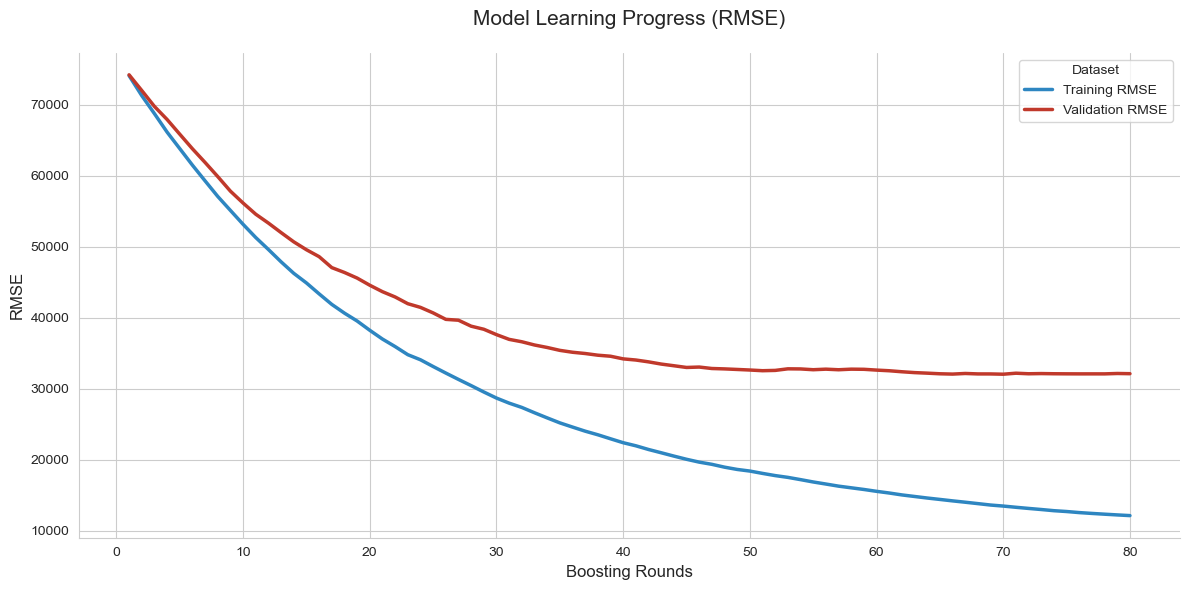

In [250]:
# Set up professional styling
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
custom_palette = ["#2E86C1", "#C0392B", "#27AE60", "#8E44AD", "#F1C40F"]
sns.set_palette(custom_palette)

# Create professional learning curve plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, len(results['validation_0']['rmse'])+1), y=results['validation_0']['rmse'], label='Training RMSE', linewidth=2.5)
sns.lineplot(x=range(1, len(results['validation_1']['rmse'])+1), y=results['validation_1']['rmse'], label='Validation RMSE', linewidth=2.5)

plt.title('Model Learning Progress (RMSE)', fontsize=15, pad=20)
plt.xlabel('Boosting Rounds', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.legend(title='Dataset', frameon=True)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.grid(False)
sns.despine()
plt.tight_layout()
plt.show()

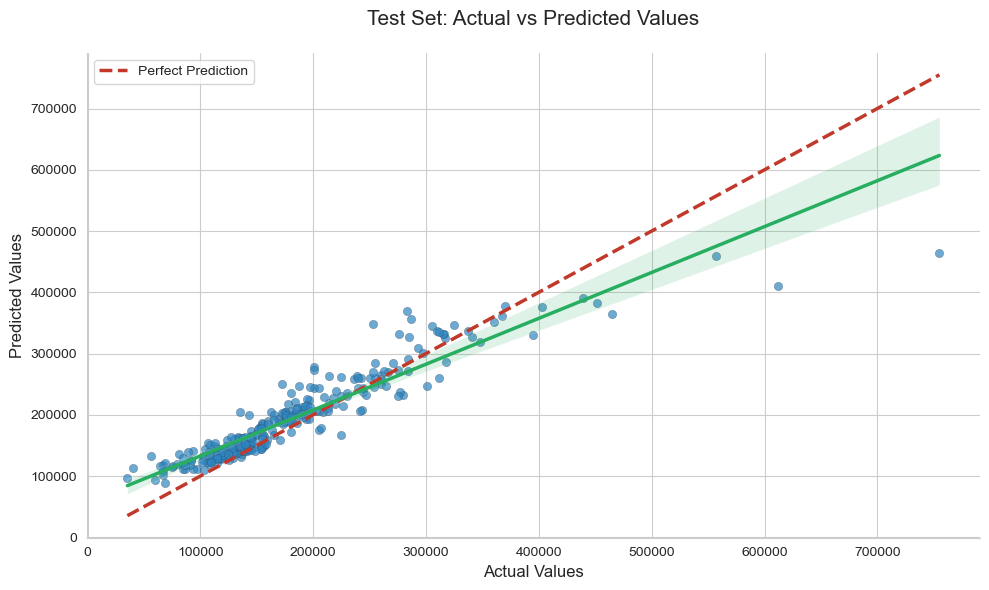

In [251]:
#actual vs predicted plot
y_test_pred = final_model.predict(X_test)

plt.figure(figsize=(10, 5))
ax = sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.7, edgecolor='#34495e', linewidth=0.3,palette=["#2E86C1"])
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='#C0392B', linewidth=2.5, label='Perfect Prediction')
sns.regplot(x=y_test, y=y_test_pred, scatter=False, color='#27AE60', line_kws={'linewidth': 2.5})

plt.title('Test Set: Actual vs Predicted Values', fontsize=13, pad=20)
plt.xlabel('Actual Values', fontsize=10)
plt.ylabel('Predicted Values', fontsize=10)
plt.legend()
plt.grid(False)
sns.despine()
plt.tight_layout()
plt.show()

### **Prediction on Real Data**

In [241]:
test_df.head(3)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave  None      Reg   
1  1462          20       RL         81.0    14267   Pave  None      IR1   
2  1463          60       RL         74.0    13830   Pave  None      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl        NAmes      Feedr   
1         Lvl    AllPub    Corner       Gtl        NAmes       Norm   
2         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     1Story            5            6       1961   
1       Norm     1Fam     1Story            6            6       1958   
2       Norm     1Fam     2Story            5            5       1997   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          1961     Gable  CompShg     VinylSd     VinylSd       None   
1          1958       Hip  CompShg     Wd Sdng     Wd Sdng    BrkFace   
2          1998     Gable  CompShg     VinylSd     VinylSd       None   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0         0.0        TA        TA     CBlock       TA       TA           No   
1       108.0        TA        TA     CBlock       TA       TA           No   
2         0.0        TA        TA      PConc       Gd       TA           No   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          Rec       468.0          LwQ       144.0      270.0        882.0   
1          ALQ       923.0          Unf         0.0      406.0       1329.0   
2          GLQ       791.0          Unf         0.0      137.0        928.0   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        TA          Y      SBrkr       896         0             0   
1    GasA        TA          Y      SBrkr      1329         0             0   
2    GasA        Gd          Y      SBrkr       928       701             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0        896           0.0           0.0         1         0             2   
1       1329           0.0           0.0         1         1             3   
2       1629           0.0           0.0         2         1             3   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          TA             5        Typ           0        None   
1             1          Gd             6        Typ           0        None   
2             1          TA             6        Typ           1          TA   

  GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual  \
0     Attchd       1961.0          Unf         1.0       730.0         TA   
1     Attchd       1958.0          Unf         1.0       312.0         TA   
2     Attchd       1997.0          Fin         2.0       482.0         TA   

  GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
0         TA          Y         140            0              0          0   
1         TA          Y         393           36              0          0   
2         TA          Y         212           34              0          0   

   ScreenPorch  PoolArea PoolQC  Fence MiscFeature  MiscVal  MoSold  YrSold  \
0          120         0   None  MnPrv        None        0       6    2010   
1            0         0   None   None        Gar2    12500       6    2010   
2            0         0   None  MnPrv        None        0       3    2010   

  SaleType SaleCondition  
0       WD        Normal  
1       WD        Normal  
2       WD        Normal

In [242]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [249]:
# 1. Get the best model directly from GridSearchCV
best_model = gcv.best_estimator_

# 2. Train with validation monitoring using original splits
eval_set = [(X_train, y_train), (X_val, y_val)]

eval_set

[(      MSSubClass  LotFrontage    LotArea  Street  Utilities  LandSlope  \
  683           20     4.510860   9.328035       1          0          0   
  1077          20     4.208627   9.672249       1          0          0   
  463           70     4.317488   9.391745       1          0          1   
  657           70     4.110874   8.881975       1          0          1   
  835           20     4.110874   9.169623       1          0          0   
  837          160     3.091042   7.427144       1          0          0   
  248           60     4.290459   9.334150       1          0          0   
  815           20     3.891820   9.404096       1          0          0   
  1000          20     4.317488   9.230829       1          0          0   
  947           20     4.454347   9.584452       1          0          0   
  467           70     4.382027   9.157045       1          0          0   
  6             20     4.330733   9.218804       1          0          0   
  721       